# Smoke_Pollution Estimates(ODell Data)

This notebook analyzes relative levels of pollution on "Smoke Days" and "Non Smoke Days."  It also saves a summary of average annual fire related PM25 to a CSV file.  


# License
The code in this notebook was developed by Sue Boyd in support of the Course Project Assignment in DATA 512, a course in the UW MS Data Science degree program. The code in this notebook is provided under the MIT license located in the same repository as this notebook.

# Chat GPT Attribution
Selected functions or codeblocks in this Notebook were created with assistance from Chat GPT (https://chat.openai.com/). For any function or codeblock that was created with assistance from Chat GPT, the impacted code is isolated in a function or procedure and the use of Chat GPT is noted. Information on the prompts used to query Chat GPT isprovided at the end of the file. 

# Step 0: Prepare Notebook

In [1]:
import pandas as pd
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats

# Step 1:  Load Data 

Load the O'Dell PM25 Smoke Estimates 2006-2018 and add some indicator columns

In [2]:
fp = "Data/Odell_Smoke.csv" 
pm25 = pd.read_csv(fp)
pm25.head()

,date,PM25,HMS_Smoke,Background_PM25,Month,Month Number,Year,Fire_Season
0,2006-01-01,10.129988,0.0,8.810804,January,1,2006,False
1,2006-01-02,10.582376,0.0,8.810804,January,1,2006,False
2,2006-01-03,11.286818,0.0,8.810804,January,1,2006,False
3,2006-01-04,8.525418,0.0,8.810804,January,1,2006,False
4,2006-01-05,2.264996,0.0,8.810804,January,1,2006,False


In [3]:
# define a constant we'll need later 
DATA_YEARS = pm25["Year"].drop_duplicates().tolist()
DATA_YEARS

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

# Step 2: Basic Analytics - Odell Data (Krieged PM25 + Smoke Flag)
Inspect Odell data smoke estimates and perform some basic analytics. 

In [4]:
# Check for any negative smoke_pm25 daily readings

negs = pm25["PM25"] < 0 
print(len(negs))
print(sum(negs))
pm25[negs].head()


4748
0


,date,PM25,HMS_Smoke,Background_PM25,Month,Month Number,Year,Fire_Season


Good, no negative readings which would be not physically possible 

In [5]:
# Let's examine the distribution of "smoke" days

smoke_day_tbl_mo = pd.pivot_table(pm25, values =['HMS_Smoke'], index=['Month Number'], \
                     aggfunc='sum', margins = True)

smoke_day_tbl_yr = pd.pivot_table(pm25, values =['HMS_Smoke'], index=['Month Number'], columns=["Year"], \
                     aggfunc='sum', margins = True)
smoke_day_tbl_mo

,HMS_Smoke
Month Number,
1,0.0
2,0.0
3,2.0
4,22.0
5,29.0
6,105.0
7,132.0
8,178.0
9,90.0


This distribution generally matches expectation that "fire season" is months 5-10 (May - October) with a few values in March, April and one in November. 

In [6]:
# Calculate annual PM25 statistics based on ODell(Krieged/Smoke Flag) Data  

#Summarize ODell(Krieged/Smoke Flag) Data  
grouped_data = pm25.groupby(['Year','HMS_Smoke'])['PM25'].mean().reset_index()
x = grouped_data["Year"].drop_duplicates()
x = x.reset_index(drop=True)
y1 = grouped_data[grouped_data["HMS_Smoke"]== 0]["PM25"]  # mean PM25 on no-smoke days
y1 = y1.reset_index(drop=True)
y2 = grouped_data[grouped_data["HMS_Smoke"]== 1]["PM25"]  # mean PM25 on smoke days
y2 = y2.reset_index(drop=True)
y3=y2-y1  # annual difference in means, smoke days - non-smoke days

# To get annual average increase in PM25 due to smoke, multiply diff in means 
#  by number of smoke days in the year and then divide all by 365  

i = 0
cols = smoke_day_tbl_yr.columns
smoke_days_all = []
y4 = []

for yr in x:
    num_smoke_days = smoke_day_tbl_yr[cols[i]].iloc[12]
    y4.append(y3[i]*num_smoke_days/365)
    smoke_days_all.append(num_smoke_days)
    i +=1
    #print(f"for_{yr}_number of smoke days is_{num_smoke_days})



pm25_summary = pd.DataFrame({
    'Year': x,
    "Mean PM25 Smoke Days": y2,
    "Mean PM25 Non-Smoke Days": y1,
    'Diff in Mean PM25': y3,
    "Num Smoke Days": smoke_days_all,
    'Avg. Annual Delta_PM25': y4
})    
    
pm25_summary.head()    

,Year,Mean PM25 Smoke Days,Mean PM25 Non-Smoke Days,Diff in Mean PM25,Num Smoke Days,Avg. Annual Delta_PM25
0,2006,9.962489,9.129669,0.832820,25.0,0.057042
1,2007,11.532424,10.237317,1.295107,30.0,0.106447
2,2008,13.020036,10.141664,2.878372,40.0,0.315438
3,2009,8.738054,7.630536,1.107518,18.0,0.054617
4,2010,6.578359,7.080457,-0.502098,17.0,-0.023385


In [7]:
# Sanity check my average Fire Related PM25 over the time period 2006-2018
ave = pm25_summary["Avg. Annual Delta_PM25"].mean()  
round(ave, 2)

0.28

Delta_PM25 values look reasonable. O'Dell et. al. found that the mean smoke related PM25 for Nebraska for 2006-2018 was between 0.14 and .41 (depending on which part of Nebraska) so my average of .28 is reasonable. See O'Dell p. 6, Map in Figure 1(a)

In [8]:
# Calculate overall mean by year - including smoke and nonsmoke 
all_yr_mean = pm25.groupby(['Year'])['PM25'].mean().reset_index()
all_yr_mean.head()

,Year,PM25
0,2006,9.186712
1,2007,10.343764
2,2008,10.456240
3,2009,7.685154
4,2010,7.057071


In [9]:
# Add to summary dataframe 
pm25_summary["Annual Mean Combined"] = all_yr_mean["PM25"]
pm25_summary.head()

,Year,Mean PM25 Smoke Days,Mean PM25 Non-Smoke Days,Diff in Mean PM25,Num Smoke Days,Avg. Annual Delta_PM25,Annual Mean Combined
0,2006,9.962489,9.129669,0.832820,25.0,0.057042,9.186712
1,2007,11.532424,10.237317,1.295107,30.0,0.106447,10.343764
2,2008,13.020036,10.141664,2.878372,40.0,0.315438,10.456240
3,2009,8.738054,7.630536,1.107518,18.0,0.054617,7.685154
4,2010,6.578359,7.080457,-0.502098,17.0,-0.023385,7.057071


In [10]:
# save to file
f_out = "Data/Annual Summary PM25 Data ODell.csv"
pm25_summary.to_csv(f_out, index = False)

In [11]:
# Now summarize by year and month 

MONTH_NOS = [1,2,3,4,5,6,7,8,9,10,11,12]

summary_months = pd.DataFrame()

for yr in DATA_YEARS:
    new_sum = pd.DataFrame()
    new_sum["Month Number"] = MONTH_NOS
    new_sum["Year"] = yr
    dat = pm25[pm25["Year"] == yr]
    
    dat_no_smoke = dat[dat["HMS_Smoke"] == 0]
    no_smoke_grouped = dat_no_smoke.groupby(['Month Number'])['PM25'].mean().reset_index()
    new_sum["Mean PM25 Non-Smoke Days"] = no_smoke_grouped["PM25"]
    
    dat_smoke = dat[dat["HMS_Smoke"] == 1]
    smoke_grouped = dat_smoke.groupby(['Month Number'])['PM25'].mean().reset_index()
    new_sum = new_sum.merge(smoke_grouped, left_on = "Month Number", right_on = "Month Number", how='left')
    new_sum.rename(columns={'PM25': 'Mean PM25 Smoke Days'}, inplace=True)
    
    summary_months = pd.concat([summary_months, new_sum], ignore_index=True)                                                            

    
summary_months['Date'] = pd.to_datetime(summary_months['Year'].astype(str) + '-' + \
                                      summary_months['Month Number'].astype(str), format='%Y-%m')
  
summary_months.head() 


,Month Number,Year,Mean PM25 Non-Smoke Days,Mean PM25 Smoke Days,Date
0,1,2006,7.931634,NaN,2006-01-01
1,2,2006,7.609077,NaN,2006-02-01
2,3,2006,10.128305,NaN,2006-03-01
3,4,2006,9.501995,16.736535,2006-04-01
4,5,2006,8.306632,10.330054,2006-05-01


# Step 3A Compare/Graph Annual Smoke Day Mean vs. No-Smoke Day Mean

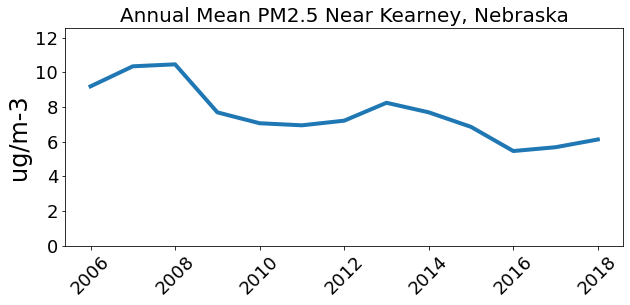

In [12]:
# Graph Mean PM25 By Year (O'Dell Data)

x = pm25_summary["Year"]
y0 = pm25_summary["Annual Mean Combined"]


# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y0, linewidth=4)
#plt.xlabel("Year")
plt.ylabel("ug/m-3", fontsize = 24)
plt.xticks(rotation=45, fontsize = 18)  # Rotate the tick labels for better visibility
plt.yticks(fontsize = 18)
max_y_value = max(y0)*1.2
ax.set_ylim(0, max_y_value)


f_out = "Visuals/Figure 3A.jpg"
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)



plt.title("Annual Mean PM2.5 Near Kearney, Nebraska", fontsize=20)
plt.show(); 



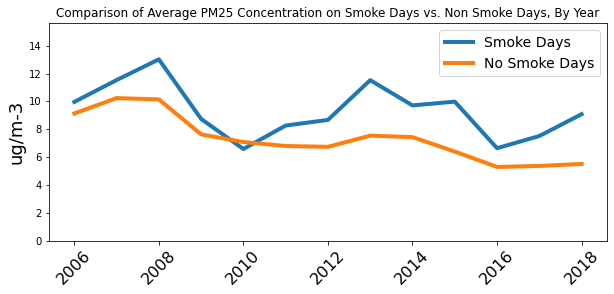

In [13]:
# Graph annual averages, smoke days and non smoke days (O'Dell Data)
x = pm25_summary["Year"]
y2 = pm25_summary["Mean PM25 Smoke Days"]
y1 = pm25_summary["Mean PM25 Non-Smoke Days"]


# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y2, label= "Smoke Days", linewidth = 4)
ax.plot(x, y1, label= "No Smoke Days", linewidth = 4)
#ax.plot(x, y3, label = "Annual Mean PM25 - Raw EPA Data")
#plt.xlabel("Year")
max_y_value = max(y2)*1.2
ax.set_ylim(0, max_y_value)
plt.ylabel("ug/m-3", fontsize = 18)
plt.xticks(rotation=45, fontsize = 16)  # Rotate the tick labels for better visibility
plt.legend(fontsize = 14)

# save plot
f_out = "Visuals/Figure 4.jpg"
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)

# Add title and display
plt.title("Comparison of Average PM25 Concentration on Smoke Days vs. Non Smoke Days, By Year")
plt.show(); 


In [14]:
# two-sample t-test to see if difference in means could just be coincidence
smoke_means = pm25_summary["Mean PM25 Smoke Days"]
no_smoke_means = pm25_summary["Mean PM25 Non-Smoke Days"]
ttest = stats.ttest_rel(smoke_means, no_smoke_means)
pval = ttest[1]
pval



0.00010686349388464996

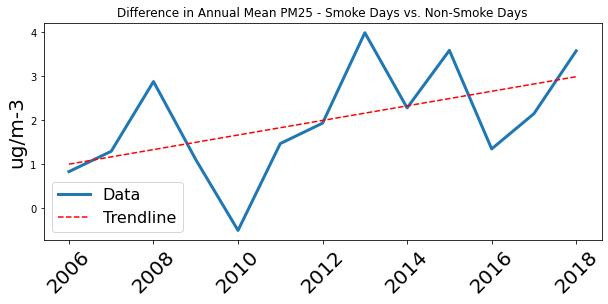

In [15]:
# Graph difference in PM25 averages, smoke/non-smoke days, per year and trendline
# Please see chat GPT attribution at end of notebook 

x = pm25_summary["Year"]
y3 = pm25_summary["Diff in Mean PM25"]


# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y3, label = "Data", linewidth =3)
#plt.xlabel("Year")
plt.ylabel("ug/m-3", fontsize = 20)
plt.xticks(rotation=45, fontsize = 20)  # Rotate the tick labels for better visibility

# Fit a linear trendline using numpy.polyfit
degree = 1  
coefficients = np.polyfit(x, y3, degree)
trendline = np.polyval(coefficients, x)

# plot trendline  & legend
ax.plot(x, trendline, label="Trendline", linestyle="--", color="red")  # Plotting the trendline
plt.legend(fontsize = 16)  # Display legend


\
# Add title and display
plt.title("Difference in Annual Mean PM25 - Smoke Days vs. Non-Smoke Days")
plt.show();

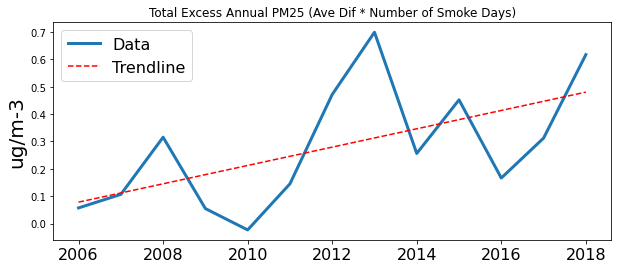

In [16]:
# Graph total annual impact - dif in mean * tot number of days 

x = pm25_summary["Year"]
y4 = pm25_summary["Diff in Mean PM25"]*pm25_summary["Num Smoke Days"]/365


# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y4, label = "Data", linewidth =3)
#plt.xlabel("Year")
plt.ylabel("ug/m-3", fontsize = 20)
plt.xticks(fontsize = 16)  # Rotate the tick labels for better visibility

# Fit a linear trendline using numpy.polyfit
degree = 1  # 1 for a linear trendline, you can change this for higher-degree polynomials
coefficients = np.polyfit(x, y4, degree)
trendline = np.polyval(coefficients, x)

# plot trendline & legend 
ax.plot(x, trendline, label="Trendline", linestyle="--", color="red")  # Plotting the trendline
plt.legend(fontsize = 16)  # Display legend



# save plot
f_out = "Visuals/Figure 7.jpg"
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)


#Add title and display
plt.title("Total Excess Annual PM25 (Ave Dif * Number of Smoke Days)")
plt.show(); 



# Step 3B - Graph Monthly Smoke Day Mean vs. Non-Smoke Day Mean

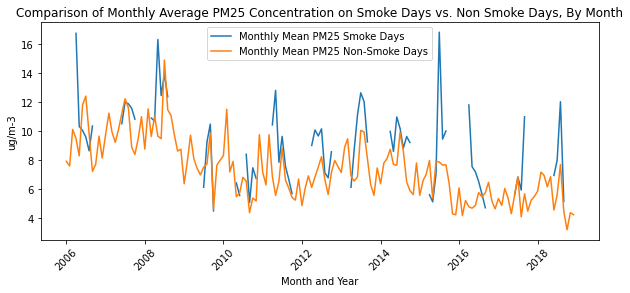

In [17]:
# Graph monthly averages, smoke days and non smoke days 

x = summary_months["Date"]
y2 = summary_months["Mean PM25 Non-Smoke Days"]
y3 = summary_months["Mean PM25 Smoke Days"]


# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y3, label= "Monthly Mean PM25 Smoke Days")
ax.plot(x, y2, label = "Monthly Mean PM25 Non-Smoke Days")

plt.xlabel("Month and Year")
plt.ylabel("ug/m-3")
plt.xticks(rotation=45)  # Rotate the tick labels for better visibility
plt.legend()



# save plot
f_out = "Visuals/Figure 5.jpg"
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)


#Add title and display
plt.title("Comparison of Monthly Average PM25 Concentration on Smoke Days vs. Non Smoke Days, By Month")
plt.show(); 





In [18]:
# two-sample t-test to see if difference in means could just be coincidence
summary_months_slim = summary_months.dropna()
smoke_means_mo = summary_months_slim["Mean PM25 Smoke Days"]
no_smoke_means_mo = summary_months_slim["Mean PM25 Non-Smoke Days"]
ttest = stats.ttest_rel(smoke_means_mo, no_smoke_means_mo)
pval = ttest[1]
print(pval)


1.320166573758826e-08


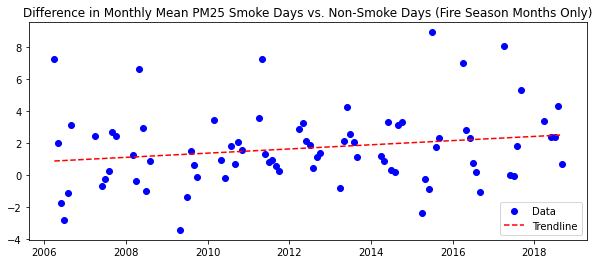

In [19]:
# Graph difference in PM25 averages, smoke/non-smoke days, per month and trendline
# Please see chat GPT attribution at end of notebook 

summary_months_drop = summary_months.dropna()


x = (summary_months_drop["Date"])
x_num = mdates.date2num(x)
y4 = summary_months_drop["Mean PM25 Smoke Days"] - summary_months_drop["Mean PM25 Non-Smoke Days"]



# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(x, y4, color='blue', marker='o', label='Data')
#ax.plot(x, y4, label = "Data")
#plt.xlabel("Date")

#plt.xticks(rotation=45)  # Rotate the tick labels for better visibility
plt.title("Difference in Monthly Mean PM25 Smoke Days vs. Non-Smoke Days (Fire Season Months Only)")

# Fit a linear trendline using numpy.polyfit
degree = 1  # 1 for a linear trendline, you can change this for higher-degree polynomials
coefficients = np.polyfit(x_num, y4, degree)
trendline = np.polyval(coefficients, x_num)

# plot trendline  
ax.plot(x_num, trendline, label="Trendline", linestyle="--", color="red")  # Plotting the trendline

plt.legend()  # Display legend
plt.show()


# Step 3C Plot Smoke Day - Season Background for Smoke Days (O'Dell Method)

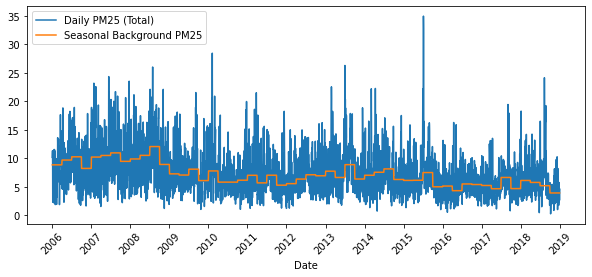

In [20]:
# plot PM25 background and daily PM25 estimates 
# See Chat GPT attribution at end of notebook 


pm25["date"] = pd.to_datetime(pm25["date"])

x = pm25["date"]
y1 = pm25["PM25"]
y2 = pm25["Background_PM25"]


fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y1, label="Daily PM25 (Total)")
ax.plot(x, y2, label="Seasonal Background PM25")


# Set Yearly Tickmarks
# Format x-axis ticks for yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel("Date")
plt.xticks(rotation=45)  # Rotate the tick labels for better visibility
plt.legend()

plt.show();

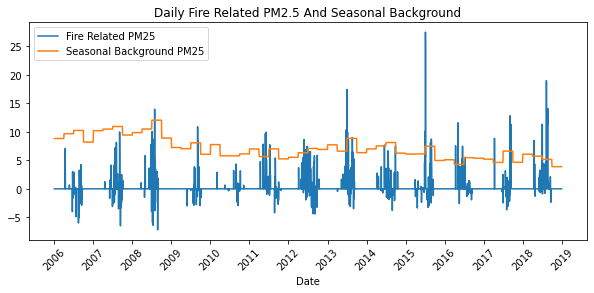

In [21]:
# now plot PM25 background and daily SMOKE-PM25 estimates 

x = pm25["date"]
y1 = pm25["PM25"] 
y2 = pm25["Background_PM25"]
pm25["Fire Related PM25"] =(y1-y2)*pm25["HMS_Smoke"]
y3 = pm25["Fire Related PM25"]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y3, label="Fire Related PM25")
ax.plot(x, y2, label="Seasonal Background PM25")

# Set Yearly Tickmarks
# Format x-axis ticks for yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel("Date")
plt.xticks(rotation=45)  # Rotate the tick labels for better visibility
plt.legend()


# save plot
f_out = "Visuals/Figure 6.jpg"
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)


#Add title and display
plt.title("Daily Fire Related PM2.5 And Seasonal Background")
plt.show(); 






(567, 9)


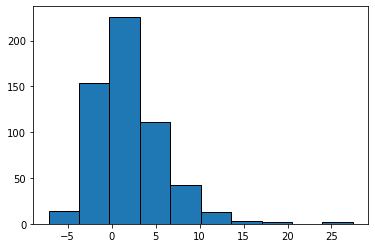

In [22]:
# Dataframe with just smoke days 
fire_pm = pm25[pm25['Fire Related PM25'] != 0]
print(fire_pm.shape)
#fire_pm.head()

# Histogram of Fire_Related_PM25 values 
plt.hist(fire_pm["Fire Related PM25"], bins=10, edgecolor='black')
plt.show();

Hmmm . .  that's a lot of "smoke days" that are lower than the seasonal average, something to keep in mind as a limiation of the anlaysis.  Clearly the method for disaggregating fire related PM2.5 and other cause PM2.5 is not perfect! 

In [23]:
# t-test whether mean of the true daily dif is >0 versus null hypothesis that it is actually zero 
# use two sided test as its more conservative even though we are really testing H0: mean is zero, versus HA mean>0

# H0 - true mean in population of Fire Related PM2.5 values is zero 
popmean = 0

# t-test 
stats.ttest_1samp(fire_pm["Fire Related PM25"], popmean)

TtestResult(statistic=11.918722929197468, pvalue=2.2339520760995701e-29, df=566)

Yes, its statistically significantly different than zero 

# Step 4 - Estimate Yearly Smoke Impact 

In [24]:
# For convenience, display again number of smoke days per year
smoke_day_tbl_yr

HMS_Smoke                                                        \
Year              2006  2007  2008  2009  2010  2011  2012  2013  2014  2015   
Month Number                                                                   
1                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3                  0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
4                  1.0   1.0   2.0   0.0   0.0   1.0   2.0   1.0   2.0   7.0   
5                  1.0   0.0   1.0   1.0   1.0   3.0  10.0   2.0   3.0   2.0   
6                  5.0   5.0   7.0   0.0   4.0  14.0  18.0  14.0   2.0   4.0   
7                  6.0   5.0  17.0   3.0   0.0   5.0  20.0  19.0  18.0   9.0   
8                  6.0   8.0  12.0   5.0   3.0   6.0  25.0  21.0   9.0  19.0   
9                  6.0  10.0   0.0   8.0   5.0   5.0  13.0   7.0   6.0   5.0   
10                 0.0   1.0   0.0   1.0   2.0   2.0   1.0   0.0   1.0   0.0   
11                 0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
12                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
All               25.0  30.0  40.0  18.0  17.0  36.0  89.0  64.0  41.0  46.0   

                                       
Year          2016  2017  2018    All  
Month Number                           
1              0.0   0.0   0.0    0.0  
2              0.0   0.0   0.0    0.0  
3              0.0   0.0   0.0    2.0  
4              1.0   1.0   3.0   22.0  
5              5.0   0.0   0.0   29.0  
6             16.0   3.0  13.0  105.0  
7              8.0   6.0  16.0  132.0  
8             11.0  29.0  24.0  178.0  
9              4.0  14.0   7.0   90.0  
10             0.0   0.0   0.0    8.0  
11             0.0   0.0   0.0    1.0  
12             0.0   0.0   0.0    0.0  
All           45.0  53.0  63.0  567.0

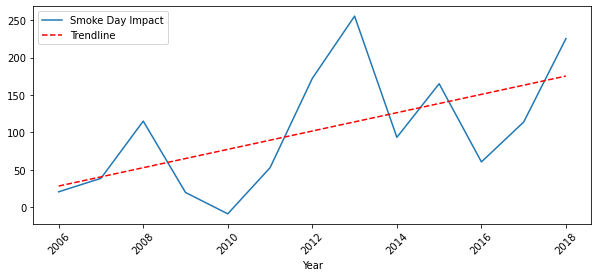

,Year,Diff,Num Days,Tot Impact
0,2006,0.832820,25.0,20.820488
1,2007,1.295107,30.0,38.853217
2,2008,2.878372,40.0,115.134885
3,2009,1.107518,18.0,19.935323
4,2010,-0.502098,17.0,-8.535658
5,2011,1.470481,36.0,52.937299
6,2012,1.934182,89.0,172.142165
7,2013,3.987276,64.0,255.185647
8,2014,2.280464,41.0,93.499015
9,2015,3.586932,46.0,164.998856


In [25]:
# Graph smoke day impacts using Kriged ODell Data 
# And annual mean smoke days - annual mean non-smoke days 


#Kriged Data 
grouped_data = pm25.groupby(['Year','HMS_Smoke'])['PM25'].mean().reset_index()
x = grouped_data["Year"].drop_duplicates()
x = x.reset_index(drop=True)
y1 = grouped_data[grouped_data["HMS_Smoke"]== 0]["PM25"]  # mean PM25 on no-smoke days
y1 = y1.reset_index(drop=True)
y2 = grouped_data[grouped_data["HMS_Smoke"]== 1]["PM25"]  # mean PM25 on smoke days
y2 = y2.reset_index(drop=True)
#grouped_data.head(10)
y3=y2-y1


# Multiply by number of smoke days in the year 
i = 0
cols = smoke_day_tbl_yr.columns
smoke_days_all = []
y4 = []

for yr in x:
    num_smoke_days = smoke_day_tbl_yr[cols[i]].iloc[12]
    y4.append(y3[i]*num_smoke_days)
    smoke_days_all.append(num_smoke_days)
    i +=1
    #print(f"for_{yr}_number of smoke days is_{num_smoke_days})



# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
#ax.plot(x, y3, label= "Smoke Day Diff")
ax.plot(x, y4, label= "Smoke Day Impact")
plt.xlabel("Year")
plt.xticks(rotation=45)  # Rotate the tick labels for better visibility

 
# Fit a linear trendline using numpy.polyfit
degree = 1  # 1 for a linear trendline, you can change this for higher-degree polynomials
coefficients = np.polyfit(x, y4, degree)
trendline = np.polyval(coefficients, x)


# plot trendline  
ax.plot(x, trendline, label="Trendline", linestyle="--", color="red")  # Plotting the trendline

# show plot
plt.legend(); 
plt.show();


summary = pd.DataFrame({
    'Year': x,
    'Diff': y3,
    "Num Days": smoke_days_all,
    'Tot Impact': y4
})


summary

# Chat GPT ATTRIBUTION 

The following function(s) or codeblock(s) contained in this notebook were written with assistance from Chat GPT available at: https://chat.openai.com/. In some cases, code suggested by Chat GPT was then further modified by the Notebook author, Sue Boyd.

***

For assistance in writing the code block "# Graph difference in PM25 averages, smoke/non-smoke days, per month and trendline",
chat GPT was given the following prompt: 

"I made a graph with this code: 

x = pm25_summary["Year"]
y3 = pm25_summary["Diff in Mean PM25"]
#Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y3)
plt.xlabel("Year")
plt.xticks(rotation=45)  # Rotate the tick labels for better visibility
plt.title("Difference in Mean PM25 - Smoke Days vs. Non-Smoke Days")
plt.show();    

Add a trendline"

***
For assistance in writing the code blcocks "plot PM25 background and daily PM25 estimates" and # now plot PM25 background and daily SMOKE-PM25 estimates,  subblock "# Set Yearly Tickmarks", in the code block " Chat GPT was given the following prompts:

"I made a plot with the following code: 
x = pm25["date"] 
y1 = pm25["PM25"] 
y2 = pm25["Background_PM25"]
plt.figure(figsize=(10, 4))
plt.plot(x, y1, label="Daily PM25")
plt.plot(x, y2, label= "Seasonal Background PM25")
plt.xlabel("Date")
plt.xticks([])
plt.legend()    

Now I want to add tickmarks based on the column  pm25["date"] but I only want to display the values at yearly intervals.  E.g. Jan 1, 2006, Jan 1, 2007 etc. "

AND

"I have this code: x = pm25["date"]
y1 = pm25["PM25"]
y2 = pm25["Background_PM25"]
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y1, label="Daily PM25 (Total)")
ax.plot(x, y2, label="Seasonal Background PM25")

_# Set Yearly Tickmarks
_# Format x-axis ticks for yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel("Date")
plt.xticks(rotation=45)  # Rotate the tick labels for better visibility
plt.legend()

plt.show();   

The data in pm25["date"] is " 0 2006-01-01
1       2006-01-02
2       2006-01-03
3       2006-01-04
4       2006-01-05."  

But the axis labels are starting in 1970 (dates which are not in the dataset).  Can you fix the code?"

***